# Load dependencies

In [5]:
import glob
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from morfeus import Sterimol,BuriedVolume,read_xyz
from script.read_FOMO import read_FOMO
from script.charge import read_charge
from script.bond import gen_alk_bond_length_map,gen_sub_bond_length_map,gen_acid_bond_length_map
from script.wbo import gen_bond_wbo_map
from script.utils import maxminscale

# Generate descriptor

In [6]:
data=pd.read_csv('./data/data.csv')
sub_smi=data['Substrate SMILES'].to_list()
alk_smi=data['Alkene SMILES'].to_list()
acid_smi=data['Acid SMILES'].to_list()
sub_smi_set=set(sub_smi)
alk_smi_set=set(alk_smi)
acid_smi_set=set(acid_smi)
temp=np.array(data[ 'Temp /C'].to_list())[:69]+273.15
ee= np.array(data['ee'].to_list())/100
ee= np.array(ee[:69])
ddg=np.array(-8.314*temp*np.log((1-ee)/(1+ee))/4184)
tem=maxminscale(np.array(data['Temp /C'].to_list())).reshape(-1,1)

for index,i in enumerate(acid_smi[:69]):
    for j in acid_smi[69:]:
        if Chem.MolToSmiles(Chem.MolFromSmiles(i))==Chem.MolToSmiles(Chem.MolFromSmiles(j)) and i!=j:
            acid_smi[index]=j
acid_smi_set=set(acid_smi)
acid_index=list(range(59,69))

In [7]:
xyz_fn_map = pd.read_csv('./data/smiles_file_dict.csv')
match_idx = pd.read_csv('./data/match_index.csv')
smiles_fn_map = {str(fn):smi for fn,smi in zip(xyz_fn_map['file_name'].to_list(),xyz_fn_map['SMILES'].to_list())}
smiles_match_idx_map = {smi:list(map(eval,str(idx).split('-'))) for smi,idx in zip(match_idx['SMILES'].to_list(),match_idx['match_index'].to_list())}
smiles_match_idx_map['CC(C=CC=N1)=C1N2C=CC3=C2C=CC=C3']=list(AllChem.AddHs(Chem.MolFromSmiles('CC(C=CC=N1)=C1N2C=CC3=C2C=CC=C3')).GetSubstructMatch(Chem.MolFromSmiles('[H]C1=CC2=C(N1)C=CC=C2')))
smiles_fn_map['add_sub_0']='CC(C=CC=N1)=C1N2C=CC3=C2C=CC=C3'
fn_smiles_map = {smiles_fn_map[key]:key for key in smiles_fn_map}
smiles_ele_pos_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_ele_pos_map[smiles_fn_map[f.split('\\')[-1]]]=read_xyz(f+'\\xtbopt.xyz')

In [8]:
Desc_map = {}
Desc_map['sub'] = {}
for smi in sub_smi_set:
    match_index = smiles_match_idx_map[smi]
    element,positions = smiles_ele_pos_map[smi]
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
    atom = tmp_mol.GetAtomWithIdx(match_index[4])
    index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[0]])+list([match_index[3]])))
    sterimol = Sterimol(element,positions,match_index[4]+1,index2[0]+1)
    bv1 = BuriedVolume(element,positions,match_index[4]+1)
    B1 = sterimol.B_1_value
    B5 = sterimol.B_5_value
    L = sterimol.L_value
    BV = bv1.fraction_buried_volume
    Desc_map['sub'][smi] = np.array([B1,B5,L,BV])
    print(fn_smiles_map[smi],match_index[4]+1,index2[0]+1)

sub_1 10 11
sub_2 5 6
sub_6 8 7
sub_11 7 10
sub_0 5 6
sub_10 6 9
sub_9 5 4
sub_4 6 9
sub_8 6 9
sub_3 13 14
sub_5 5 6
sub_7 6 9


In [9]:
Desc_map['acid'] = {}
for smi in acid_smi_set:
    try:
        tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
        match_index = smiles_match_idx_map[smi]
        element,positions = smiles_ele_pos_map[smi]

        sterimol = Sterimol(element,positions,match_index[1]+1,match_index[2]+1)
        bv1 = BuriedVolume(element,positions,match_index[3]+1)
        bv2 = BuriedVolume(element,positions,match_index[2]+1)
        B1_1 = sterimol.B_1_value
        B5_1 = sterimol.B_5_value###
        L_1 = sterimol.L_value
        BV1_1 = bv1.fraction_buried_volume
        BV2_1 = bv2.fraction_buried_volume

        sterimol = Sterimol(element,positions,match_index[9]+1,match_index[10]+1)
        bv1 = BuriedVolume(element,positions,match_index[8]+1)
        bv2 = BuriedVolume(element,positions,match_index[10]+1)
        B1_2 = sterimol.B_1_value
        B5_2 = sterimol.B_5_value
        L_2 = sterimol.L_value
        BV1_2 = bv1.fraction_buried_volume
        BV2_2 = bv2.fraction_buried_volume

        atom = tmp_mol.GetAtomWithIdx(match_index[14])  
        sterimol = Sterimol(element,positions,match_index[14]+1,match_index[15]+1)
        bv1 = BuriedVolume(element,positions,match_index[14]+1)
        bv2 = BuriedVolume(element,positions,match_index[15]+1)
        B1_3 = sterimol.B_1_value
        B5_3 = sterimol.B_5_value
        L_3 = sterimol.L_value
        BV1_3 = bv1.fraction_buried_volume
        BV2_3 = bv2.fraction_buried_volume

        atom = tmp_mol.GetAtomWithIdx(match_index[12]) 
        sterimol = Sterimol(element,positions,match_index[12]+1,match_index[13]+1)
        bv1 = BuriedVolume(element,positions,match_index[12]+1)
        bv2 = BuriedVolume(element,positions,match_index[13]+1)
        B1_4 = sterimol.B_1_value
        B5_4 = sterimol.B_5_value
        L_4 = sterimol.L_value
        BV1_4 = bv1.fraction_buried_volume
        BV2_4 = bv2.fraction_buried_volume

        Desc_map['acid'][smi] = np.array([B1_1,B5_1,L_1,BV1_1,BV2_1,B1_2,B5_2,L_2,BV1_2,BV2_2,B1_3,B5_3,L_3,BV1_3,BV2_3,B1_4,B5_4,L_4,BV1_4,BV2_4])

        print(fn_smiles_map[smi],match_index[1]+1,match_index[2]+1,match_index[3]+1)
    except:
        print(smi)

acid_110 24 25 23
acid_448 20 21 19
acid_369 16 17 15
acid_181 24 25 23
acid_302 16 17 15
acid_184 24 25 23
acid_160 16 17 15
acid_136 24 25 23
acid_45 24 25 23
acid_173 24 25 23
acid_249 24 25 23
acid_465 24 25 23
acid_2 24 25 23
acid_308 20 21 19
acid_420 24 25 23
acid_395 24 25 23
acid_414 24 25 23
acid_254 24 25 23
acid_342 16 17 15
acid_127 24 25 23
acid_382 24 25 23
acid_471 20 21 19
acid_430 20 21 19
acid_289 20 21 19
acid_445 16 17 15
acid_393 24 25 23
acid_236 24 25 23
acid_182 20 21 19
acid_151 16 17 15
acid_74 24 25 23
acid_450 20 21 19
acid_231 20 21 19
acid_411 24 25 23
acid_270 24 25 23
acid_440 24 25 23
acid_170 16 17 15
acid_371 24 25 23
acid_375 24 25 23
acid_6 16 17 15
acid_46 24 25 23
acid_33 20 21 19
acid_374 16 17 15
acid_283 24 25 23
acid_399 24 25 23
acid_479 24 25 23
acid_234 16 17 15
acid_98 24 25 23
acid_322 24 25 23
acid_152 24 25 23
acid_141 16 17 15
acid_142 20 21 19
acid_251 16 17 15
acid_225 24 25 23
acid_353 20 21 19
acid_475 20 21 19
acid_305 24 25 23
a

In [10]:
smiles_fmo_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_fmo_map[smiles_fn_map[f.split('\\')[-1]]]=read_FOMO(f+'\\LOG')

In [11]:
smiles_charge_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_charge_map[smiles_fn_map[f.split('\\')[-1]]]=read_charge(f+'\\charges')
for smi in smiles_charge_map:
    match_index = smiles_match_idx_map[smi]
    smiles_charge_map[smi] = smiles_charge_map[smi][match_index]  

In [12]:
def sorted_match(index1,index2):
    sort_list=sorted([match_index[index1],match_index[index2]])
    return sort_list[0],sort_list[1]

In [13]:
smiles_all_wbo_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_all_wbo_map[smiles_fn_map[f.split('\\')[-1]]]=gen_bond_wbo_map(f+'\\wbo')
    
smiles_wbo_map = {}

smiles_wbo_map['sub'] = {}
for smi in sub_smi_set:
    match_index = smiles_match_idx_map[smi]
    all_wbo = smiles_all_wbo_map[smi]
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
    atom = tmp_mol.GetAtomWithIdx(match_index[0])
    index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[1]])+list([match_index[4]])))
    try:
        wbo = [all_wbo[(match_index[0],index2[0])],all_wbo[sorted_match(0,4)],
                        all_wbo[sorted_match(4,3)],all_wbo[sorted_match(3,2)],
                        all_wbo[sorted_match(2,1)],all_wbo[sorted_match(1,0)],
                        all_wbo[sorted_match(3,5)],all_wbo[sorted_match(5,6)],
                        all_wbo[sorted_match(6,7)],all_wbo[sorted_match(7,8)],
                        all_wbo[sorted_match(8,2)]]
        print(sorted_match(8,2))
        smiles_wbo_map['sub'][smi] = wbo
    except:
        wbo = [all_wbo[(index2[0],match_index[0])],all_wbo[match_index[0],match_index[4]],
                        all_wbo[match_index[3],match_index[4]],all_wbo[match_index[3],match_index[2]],
                        all_wbo[match_index[2],match_index[1]],all_wbo[match_index[1],match_index[0]],
                        all_wbo[match_index[5],match_index[3]],all_wbo[match_index[6],match_index[5]],
                        all_wbo[match_index[7],match_index[6]],all_wbo[match_index[8],match_index[7]],
                        all_wbo[match_index[8],match_index[2]]]     
        print(sorted_match(8,2))
        smiles_wbo_map['sub'][smi] = wbo
        continue

    
    
smiles_wbo_map['alk'] = {}
for smi in alk_smi_set:
    match_index = smiles_match_idx_map[smi]
    all_wbo = smiles_all_wbo_map[smi]
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))

    wbo =  [all_wbo[sorted_match(0,1)]]#,all_wbo[sorted_match(0,2)],all_wbo[sorted_match(0,3)],all_wbo[sorted_match(1,4)],all_wbo[sorted_match(1,5)
    smiles_wbo_map['alk'][smi] = wbo
            
            
smiles_wbo_map['acid'] = {}
for smi in acid_smi_set:
    match_index = smiles_match_idx_map[smi]
    all_wbo = smiles_all_wbo_map[smi]
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
    atom = tmp_mol.GetAtomWithIdx(match_index[6])
    index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[5]])))
    wbo =  [all_wbo[sorted_match(4,3)],all_wbo[sorted_match(3,14)],
            all_wbo[sorted_match(14,12)],all_wbo[sorted_match(12,8)],
            all_wbo[sorted_match(8,4)],all_wbo[sorted_match(4,5)],
            all_wbo[sorted_match(5,6)],all_wbo[sorted_match(5,7)],       
            all_wbo[sorted_match(3,1)],all_wbo[sorted_match(1,2)],
            all_wbo[sorted_match(8,9)],all_wbo[sorted_match(9,10)],
            all_wbo[sorted_match(1,0)],all_wbo[sorted_match(9,11)],
            all_wbo[sorted_match(14,15)],all_wbo[sorted_match(12,13)],
            all_wbo[(match_index[6],index2[0])]]
    smiles_wbo_map['acid'][smi] = wbo 

(1, 6)
(1, 15)
(10, 15)
(3, 4)
(1, 11)
(2, 3)
(7, 12)
(2, 3)
(2, 3)
(7, 8)
(12, 15)
(2, 3)


In [14]:
smiles_bond_length_map={}

In [15]:
smiles_bond_length_map['alk'] = {}
smiles_bond_length_map['acid'] = {}
smiles_bond_length_map['sub'] = {}
for f in glob.glob('./data/xyz_data/*'):    
    smi=smiles_fn_map[f.split('\\')[-1]]
    if smi in alk_smi_set:
        smiles_bond_length_map['alk'][smi]=gen_alk_bond_length_map(f,smi,smiles_match_idx_map)
    if smi in acid_smi_set:  
        smiles_bond_length_map['acid'][smi]=gen_acid_bond_length_map(f,smi,smiles_match_idx_map)
    if smi in sub_smi_set:
        smiles_bond_length_map['sub'][smi]=gen_sub_bond_length_map(f,smi,smiles_match_idx_map)

In [16]:
all_num=69+360
sub_bv_sterimol_desc = maxminscale(np.array([Desc_map['sub'][smi] for smi in sub_smi]))
acid_bv_sterimol_desc = maxminscale(np.array([Desc_map['acid'][smi] for smi in acid_smi]))

alk_fmo_desc = maxminscale(np.array([smiles_fmo_map[smi] for smi in alk_smi]))

sub_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in sub_smi]))
alk_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in alk_smi]))
acid_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in acid_smi]))

sub_wbo_desc = maxminscale(np.array([smiles_wbo_map['sub'][smi] for smi in sub_smi])).reshape(all_num,-1)
acid_wbo_desc = maxminscale(np.array([smiles_wbo_map['acid'][smi] for smi in acid_smi])).reshape(all_num,-1)
alk_wbo_desc = maxminscale(np.array([smiles_wbo_map['alk'][smi] for smi in alk_smi])).reshape(all_num,-1)

alk_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['alk'][smi] for smi in alk_smi])).reshape(all_num,-1)
acid_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['acid'][smi] for smi in acid_smi])).reshape(all_num,-1)
sub_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['sub'][smi] for smi in sub_smi])).reshape(all_num,-1)

des=np.concatenate([sub_bv_sterimol_desc,sub_chrg_desc,sub_wbo_desc,sub_bond_length_desc,
                    alk_fmo_desc,alk_chrg_desc,alk_wbo_desc,alk_bond_length_desc,
                    acid_bv_sterimol_desc,acid_chrg_desc,acid_wbo_desc,acid_bond_length_desc,tem],axis=1)#alk_fmo_desc

# Apply reported data to new reactions  directly

In [17]:
sel_index1=np.array([2,12,17,21,25,28,34,37,39,40,41,42,43,50,53,57,65,73,74,75,76,83,86,89,94,97,107])
des_sel1=des[:,sel_index1]
sel_index2=sel_index1
des_sel2=des[:,sel_index2]

train_index=list(range(59))
test_index=list(range(59,69))

train_x,train_y = des_sel1[train_index],ddg[train_index]
test_x,test_y = des_sel1[test_index],ddg[test_index]
model = LinearSVR()

all_pred=[]
for i in range(10):
    model.fit(train_x,train_y)
    pred =model.predict(test_x)
    all_pred.append(pred)
all_pred=np.mean(np.array(all_pred),axis=0)

C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-pack

Text(0.8500000000000001, 1.4, 'MAE: 0.210')

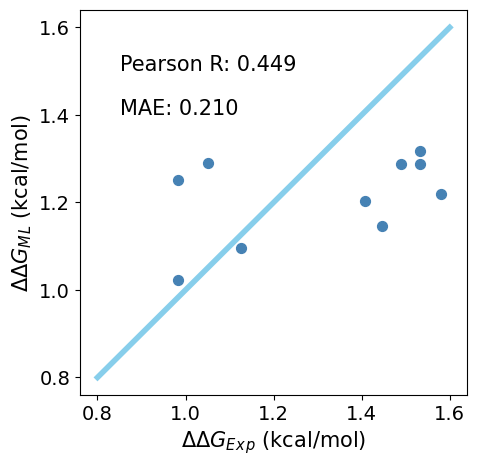

In [18]:
start_point=0.8
end_point=1.6
fig = plt.figure(figsize=(5,5))
plt.xticks(np.arange(start_point, end_point+0.1, step=0.2),fontsize=14)
plt.yticks(np.arange(start_point, end_point+0.1, step=0.2),fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=15)
plt.plot([start_point,end_point],[start_point,end_point],c='skyblue',linewidth=4)#skyblue
plt.scatter(np.array(test_y),np.array(all_pred),c='steelblue',s=50, alpha=1)#steelblue
plt.text(start_point+0.05,1.5,'Pearson R: %.3f'%pearsonr(np.array(test_y),np.array(all_pred))[0],fontsize=15)
plt.text(start_point+0.05,1.4,'MAE: %.3f'%mean_absolute_error(np.array(test_y),np.array(all_pred)),fontsize=15)

# Apply reported data to new 10 reactions with delta learning

[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]


C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Matsunami\anaconda3\envs\ARIM-v2\lib\site-pack

Text(0.8500000000000001, 1.4, 'MAE: 0.143')

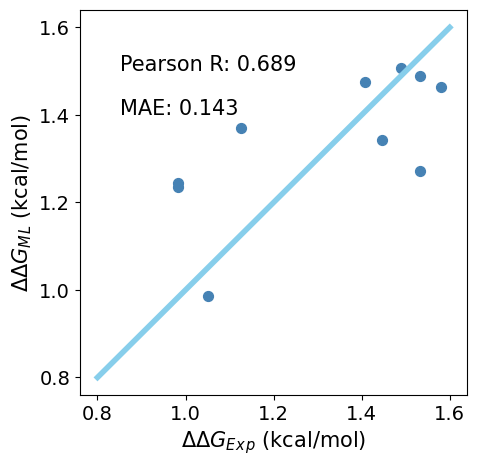

In [19]:
sel_index2=[53, 95, 106, 63, 71, 2, 19, 12, 8, 37, 40, 33, 10, 29, 34, 1, 107, 11, 28, 32, 5, 31, 35, 9, 24, 84, 50, 62, 98, 75, 74, 87, 47, 66, 89]
des_sel2=des[:,sel_index2]
delta=test_y-all_pred

all_acid_add=[]
all_acid_test=[]
for i in range(10):
    all_acid_add.append(list(set(list(range(10)))-set([i])))
    all_acid_test.append(i)
    
pred_value=[]
exp_value=[]
for j in range(10):
    tem_add=list(np.array(acid_index)[all_acid_add[j]]) 
    tem_test=[np.array(acid_index)[all_acid_test[j]]]
    print(tem_test)
    tem_val_x,tem_test_x = des_sel2[tem_add],des_sel2[tem_test]
    tem_val_y,tem_test_y= delta[all_acid_add[j]],delta[all_acid_test[j]]

    model = LinearSVR()
    tem_delta_pred=[]
    for i in range(20):
        model.fit(tem_val_x,tem_val_y)
        pred =model.predict(tem_test_x)
        #val_pred_delta.append(model.predict(val_x))
        tem_delta_pred.append(pred)
    tem_delta_pred=np.mean(np.array(tem_delta_pred),axis=0)    
    pred_value+=list(tem_delta_pred)
    exp_value.append(tem_test_y)
pred=pred_value+all_pred
start_point=0.8
end_point=1.6
fig = plt.figure(figsize=(5,5))
plt.xticks(np.arange(start_point, end_point+0.1, step=0.2),fontsize=14)
plt.yticks(np.arange(start_point, end_point+0.1, step=0.2),fontsize=14)
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=15)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=15)
plt.plot([start_point,end_point],[start_point,end_point],c='skyblue',linewidth=4)#skyblue
plt.scatter(np.array(test_y),np.array(pred),c='steelblue',s=50, alpha=1)#steelblue
plt.text(start_point+0.05,1.5,'Pearson R: %.3f'%pearsonr(np.array(test_y),np.array(pred))[0],fontsize=15)
plt.text(start_point+0.05,1.4,'MAE: %.3f'%mean_absolute_error(np.array(test_y),np.array(pred)),fontsize=15)